## Import Libraries

In [2]:
import numpy as np
import torch
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from model import get_model
import warnings

warnings.filterwarnings("ignore")

## Basic Configurations

In [3]:
# config seed for reproducible codes
SEED = 17167055
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Basic Functions

In [4]:
# load images
def loader(path):
    with open(path, "rb") as f:
        return Image.open(f).convert("RGB")


# stratified sampling
def stratified(df, col, n_smaples):
    n = min(n_smaples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

## Import Data

In [5]:
path = Path("../data/preprocess/")
data = [str(i) for i in list(path.glob("*.jpg"))]

In [6]:
df = pd.DataFrame()
df["filename"] = [i.split("\\")[-1] for i in data]
df["pixels"] = [loader(i) for i in data]
df["label"] = [int(i[0]) for i in df["filename"]]
df["id"] = ["-".join(i.split("_")[1:-2]) for i in df["filename"]]
df["var"] = [i.split(".")[0][-1] for i in df["filename"]]
df["ga"] = [i.split("_")[-2] for i in df["filename"]]

In [7]:
# remove all duplicates to make dataset more clean
df = df[df["var"] == "0"].reset_index(drop=True)

In [8]:
df

,filename,pixels,label,id,var,ga
0,0_057_21-5_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,057,0,21-5
1,0_080_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,080,0,21-3
2,0_082_21-6_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,082,0,21-6
3,0_087_21-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,087,0,21-2
4,0_096_21-6_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,096,0,21-6
...,...,...,...,...,...,...
85,1_JessTay-Sample8_21-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,JessTay-Sample8,0,21-4
86,1_May-IUGR2_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,May-IUGR2,0,21-3
87,1_May-IUGR4_22-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,May-IUGR4,0,22-0
88,1_SN-Sample12_IUGR3_22-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,SN-Sample12-IUGR3,0,22-4


In [9]:
df_duplicated = df[df.duplicated("id", keep=False)]
df_unique = df.drop(df_duplicated.index)
df_duplicated = df_duplicated.reset_index(drop=True)
df_unique = df_unique.reset_index(drop=True)

# test set
df_test = stratified(df_unique, "label", 5)
df_unique = df_unique.drop(df_test.index).reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# validation set
df_val = stratified(df_unique, "label", 5)
df_unique = df_unique.drop(df_val.index).reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# train set
df_train = pd.concat([df_duplicated, df_unique], ignore_index=True)

In [10]:
# Display label counts for each dataset
print(f"Training set : {df_train.label.count()}\n{df_train.label.value_counts()}\n")
print(f"Validation set : {df_val.label.count()}\n{df_val.label.value_counts()}\n")
print(f"Test set : {df_test.label.count()}\n{df_test.label.value_counts()}\n")

Training set : 70
0    61
1     9
Name: label, dtype: int64

Validation set : 10
0    5
1    5
Name: label, dtype: int64

Test set : 10
0    5
1    5
Name: label, dtype: int64



In [11]:
df_train

,filename,pixels,label,id,var,ga
0,0_JessTay-Sample3_20-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,JessTay-Sample3,0,20-0
1,0_JessTay-Sample3_23-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,JessTay-Sample3,0,23-2
2,0_057_21-5_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,057,0,21-5
3,0_082_21-6_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,082,0,21-6
4,0_087_21-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,087,0,21-2
...,...,...,...,...,...,...
65,1_191_S6_28-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,191-S6,0,28-4
66,1_JessTay-Sample8_21-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,JessTay-Sample8,0,21-4
67,1_May-IUGR2_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,May-IUGR2,0,21-3
68,1_May-IUGR4_22-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,May-IUGR4,0,22-0


In [12]:
df_val

,filename,pixels,label,id,var,ga
0,0_JessLow-N1_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,JessLow-N1,0,21-3
1,0_105_21-5_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,105,0,21-5
2,0_YuWei-N1_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,YuWei-N1,0,21-3
3,0_JessLow-N2_21-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,JessLow-N2,0,21-2
4,0_170_21-6_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,170,0,21-6
5,1_128_21-6_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,128,0,21-6
6,1_174_22-1_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,174,0,22-1
7,1_JessTay-Sample1_22-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,JessTay-Sample1,0,22-0
8,1_163_21-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,163,0,21-2
9,1_SN-Sample12_IUGR3_22-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,SN-Sample12-IUGR3,0,22-4


In [13]:
df_test

,filename,pixels,label,id,var,ga
0,0_172_22-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,172,0,22-0
1,0_May-N8_21-4_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,May-N8,0,21-4
2,0_143_22-1_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,143,0,22-1
3,0_JessLow-N6_22-2_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,JessLow-N6,0,22-2
4,0_080_21-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,0,080,0,21-3
5,1_169_22-1_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,169,0,22-1
6,1_161_21-0_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,161,0,21-0
7,1_177_22-3_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,177,0,22-3
8,1_188_S3_28-5_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,188-S3,0,28-5
9,1_JessTay-Sample6_22-5_0.jpg,<PIL.Image.Image image mode=RGB size=448x112 a...,1,JessTay-Sample6,0,22-5


## Data Augmentation

In [14]:
transform = {
    "train": A.Compose(
        [
            A.CLAHE(p=0.8),
            A.RandomCrop(112, 112),
            A.Normalize(
                mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    ),
    "test": A.Compose(
        [
            A.Normalize(
                mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    ),
}

## Load Dataset

In [15]:
class DopplerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img = self.df["pixels"]
        self.lbl = self.df["label"]
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.img[idx]
        lbl = self.lbl[idx]
        if self.transform:
            img = self.transform(image=np.array(img))["image"]
        return img, lbl

In [16]:
trainset = DopplerDataset(df_train, transform=transform["train"])
valset = DopplerDataset(df_val, transform=transform["test"])
testset = DopplerDataset(df_test, transform=transform["test"])

## Define NN

In [17]:
model_name = "densenet121-pretrained-adam"
model = get_model(model_name).to(DEVICE)

## Hyperparameters

In [18]:
lr = 1e-4
n_epoch = 25
bs = 16
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, weight_decay=1e-4, nesterov=True, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
# scheduler = CosineAnnealingLR(optimizer, total_epoch)

In [18]:
filename = f"{model_name}-{lr}lr-{bs}bs-{n_epoch}e"

## Weighted Random Sampler

In [20]:
# WeightedRandomSampler
class_weights = list(1 / df_train["label"].value_counts())
sample_weights = [0] * len(df_train)
for idx, row in df_train.iterrows():
    class_weight = class_weights[row["label"]]
    sample_weights[idx] = class_weight
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

## Load into DataLoader

In [21]:
trainLoader = DataLoader(trainset, batch_size=bs, sampler=sampler)
valLoader = DataLoader(valset, batch_size=1, shuffle=False)
testLoader = DataLoader(testset, batch_size=1, shuffle=False)

## Training

In [22]:
def train(epoch, loader, net, model_name):
    net.train()
    totalLoss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Training {model_name}: {epoch+1}/{n_epoch}")
    for X, y in pbar:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = net(X)
        y = y.unsqueeze(dim=1).float()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()
        pred = (torch.sigmoid(out) > 0.5).float()
        total += y.size(0)
        correct += pred.eq(y).cpu().sum()
        pbar.set_postfix({"loss": (totalLoss), "acc": (100.0 * correct / total).item()})
    acc = (100.0 * correct / total).item()
    return acc, totalLoss

In [23]:
def evaluate(epoch, loader, net, model_name):
    net.eval()
    totalLoss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Evaluating {model_name}: {epoch+1}/{n_epoch}")
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = net(X)
            y = y.unsqueeze(dim=1).float()
            loss = criterion(out, y)
            totalLoss += loss.item()
            pred = (torch.sigmoid(out) > 0.5).float()
            total += y.size(0)
            correct += pred.eq(y).cpu().sum()
            pbar.set_postfix(
                {"loss": (totalLoss), "acc": (100.0 * correct / total).item()}
            )
    acc = (100.0 * correct / total).item()
    return acc, totalLoss

In [24]:
train_acc_ = list()
train_loss_ = list()
val_acc_ = list()
val_loss_ = list()
test_acc_ = list()
test_loss_ = list()

In [24]:
best_acc = 60.0
for epoch in range(n_epoch):
    train_acc, train_loss = train(epoch, trainLoader, model, model_name)
    val_acc, val_loss = evaluate(epoch, valLoader, model, model_name)
    test_acc, test_loss = evaluate(epoch, testLoader, model, model_name)
    train_acc_.append(train_acc)
    train_loss_.append(train_loss)
    val_acc_.append(val_acc)
    val_loss_.append(val_loss)
    test_acc_.append(test_acc)
    test_loss_.append(test_loss)
    if val_acc > best_acc:
        best_acc = val_acc
        print(f"Best val {best_acc}, saving...")
        # torch.save(model, f"../model/{filename}-{best_acc}val-{epoch}e.pth")

Evaluating densenet121-pretrained-adam: 6/25: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, loss=6.75, acc=70] 


Best val 70.0, saving...


Evaluating densenet121-pretrained-adam: 8/25: 100%|██████████| 10/10 [00:00<00:00, 21.78it/s, loss=6.08, acc=80] 


Best val 80.0, saving...


Evaluating densenet121-pretrained-adam: 25/25: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, loss=6.14, acc=70] 


## Result

In [25]:
df_result = pd.DataFrame(data={
    'train_acc': train_acc_, 
    'train_loss': train_loss_,
    'val_acc': val_acc_, 
    'val_loss': val_loss_,
    'test_acc': test_acc_, 
    'test_loss': test_loss_,
    })
df_result

,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss
0,58.571430,3.548236,60.0,6.789049,60.0,7.355984
1,68.571426,2.844297,60.0,7.076290,60.0,7.208215
2,75.714287,2.757804,40.0,6.865029,60.0,7.249453
3,71.428574,2.726398,60.0,6.689795,70.0,6.986935
4,71.428574,2.723667,60.0,6.512275,70.0,6.863253
5,78.571426,2.285211,70.0,6.282682,70.0,6.750935
6,81.428574,2.553287,70.0,6.387741,60.0,6.552795
7,91.428574,1.888304,80.0,6.363212,80.0,6.080765
8,88.571426,1.883438,70.0,6.401760,80.0,6.210934
9,92.857140,1.548191,50.0,6.800099,60.0,6.418628


In [26]:
# df_result.to_csv(f'../result/{filename}.csv')

## Inference

In [25]:
cpu = torch.load(
    "../model/densenet121-pretrained-adam-0.0001lr-16bs-25e-80.0val-7e.pth",
    map_location=torch.device("cpu"),
)
cpu.eval()

def inference(loader, model):
    net = model
    y_ = list()
    pred_ = list()
    prob_ = list()
    with torch.no_grad():
        for X, y in loader:
            out = net(X)
            y = y.unsqueeze(dim=1).float()
            prob = torch.sigmoid(out)
            pred = (prob>0.5).float()
            y_.append(y.squeeze().tolist())
            pred_.append(pred.squeeze().tolist())
            prob_.append((prob*100.).squeeze().tolist())
    print(classification_report(y_true=y_, y_pred=pred_, target_names=['normal', 'fgr']))
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true=y_, y_pred=pred_), display_labels=['normal', 'fgr'])
    cm.plot()
    
    return y_, pred_
# y_, pred_ = inference(testLoader, "../model/resnet18-xpretrained-adam-0.0001lr-16bs-25e-70.0val-7e.pth")


              precision    recall  f1-score   support

      normal       0.71      1.00      0.83         5
         fgr       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0])

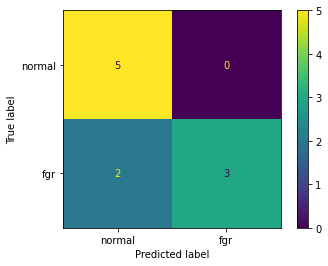

In [26]:
inference(testLoader, cpu)

In [35]:
%timeit inference(testLoader, cpu)

915 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


              precision    recall  f1-score   support

      normal       0.71      1.00      0.83         5
         fgr       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]


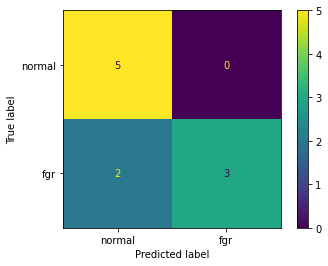

In [29]:
label, preds = inference(testLoader, cpu)

In [30]:
preds

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]

In [42]:
df_result = pd.DataFrame()
df_result['filename'] = df_test['filename']
df_result['label'] = label
df_result['pred'] = preds

In [43]:
df_result

,filename,label,pred
0,0_172_22-0_0.jpg,0.0,0.0
1,0_May-N8_21-4_0.jpg,0.0,0.0
2,0_143_22-1_0.jpg,0.0,0.0
3,0_JessLow-N6_22-2_0.jpg,0.0,0.0
4,0_080_21-3_0.jpg,0.0,0.0
5,1_169_22-1_0.jpg,1.0,0.0
6,1_161_21-0_0.jpg,1.0,1.0
7,1_177_22-3_0.jpg,1.0,1.0
8,1_188_S3_28-5_0.jpg,1.0,1.0
9,1_JessTay-Sample6_22-5_0.jpg,1.0,0.0
